In [2]:
import sys
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from matplotlib.path import Path

# Ajout du chemin vers le dossier git
sys.path.insert(0, os.path.abspath('imodal_git'))

# Imports de la librairie
import imodal
from imodal import Utilities

# Configuration
Utilities.set_compute_backend('torch')
torch.manual_seed(1337)

%load_ext autoreload
%autoreload 2
import func as f

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.


# Création des données "jouet"

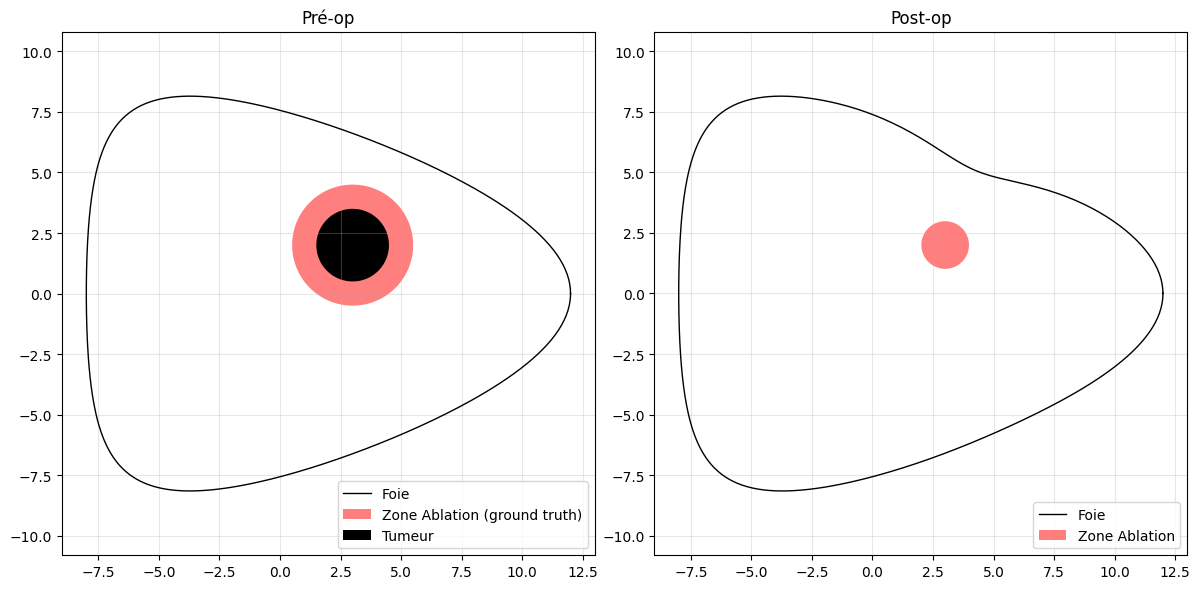

In [3]:
# DEFINITION DES PARAMETRES DES OBJETS JOUET
# Tumeur
centre_tumeur = np.array([3.0, 2.0])
rayon_tumeur = 1.5

# Zone d'ablation
marge = 1.0  # 1 cm
rayon_ablation = rayon_tumeur + marge

# Paramètres de la rétractation (ground truth)
FORCE_RETRACTATION = 1 # Assez fort pour être visible
RAYON_INFLUENCE = rayon_ablation # Assez large pour toucher les vaisseaux

# CREATION DES OBJETS JOUET (PRE-OP)
# Foie
foie_pre = f.get_liver_shape()

# Tumeur
tumeur_pre = f.get_circle(centre_tumeur, rayon_tumeur)

# Zone d'Ablation (ground truth)
zone_ablation_pre = f.get_circle(centre_tumeur, rayon_ablation)

# SIMULATION DE L'INTERVENTION (POST-OP)
# On applique ta fonction apply_retraction à TOUT le monde
foie_post = f.apply_retraction(foie_pre, centre_tumeur, strength=FORCE_RETRACTATION, radius_influence=RAYON_INFLUENCE)

# Note: La tumeur n'existe plus physiquement, mais on calcule la déformation de l'espace
# La zone d'ablation visible est la version rétractée de la zone théorique
zone_ablation_post = f.apply_retraction(zone_ablation_pre, centre_tumeur, strength=FORCE_RETRACTATION, radius_influence=RAYON_INFLUENCE)

f.visualiser_intervention(
    foie_pre, 
    zone_ablation_pre, 
    tumeur_pre, 
    [],  # Votre liste spécifique de vaisseaux
    foie_post, 
    zone_ablation_post, 
    []
)

# Déformation "à la main" (pas de registration)

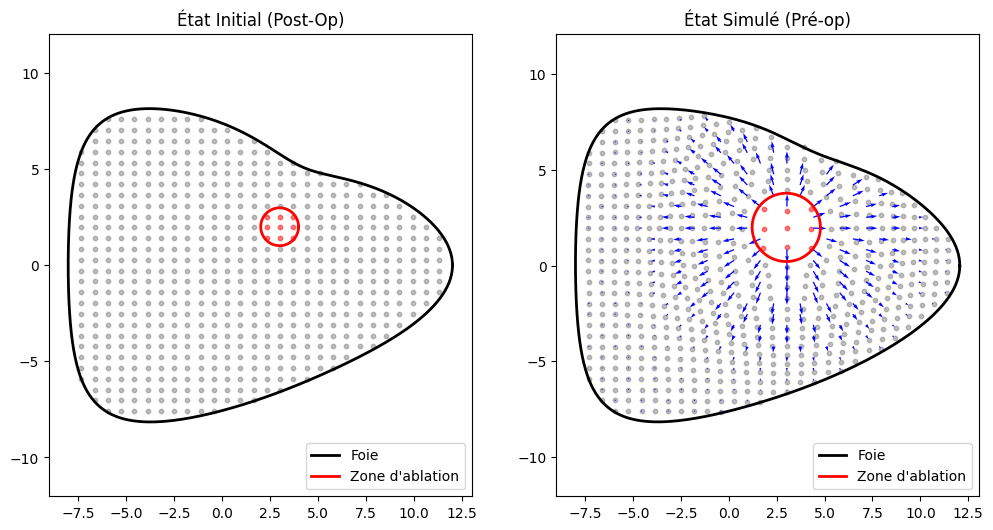

In [12]:
import torch
import imodal
import matplotlib.pyplot as plt
from matplotlib.path import Path
import numpy as np

# 0. Configuration imodal
torch.set_default_dtype(torch.float64)
imodal.Utilities.set_compute_backend('torch')

# 1. Conversion de tes objets jouet
pts_ablation = torch.tensor(zone_ablation_post, dtype=torch.get_default_dtype())
pts_foie = torch.tensor(foie_post, dtype=torch.get_default_dtype())

# ==============================================================================
# STEP 2-BIS : CRÉATION DU QUADRILLAGE (GRID)
# ==============================================================================
# On définit une grille qui couvre la bounding box du foie
min_x, min_y = np.min(foie_post, axis=0)
max_x, max_y = np.max(foie_post, axis=0)

# Densité de la grille (ex: 30 points par axe)
x_lin = np.linspace(min_x, max_x, 30)
y_lin = np.linspace(min_y, max_y, 30)
xx, yy = np.meshgrid(x_lin, y_lin)
grid_flat = np.column_stack((xx.ravel(), yy.ravel()))

# On filtre pour ne garder que les points DANS le foie
path_foie = Path(foie_post)
path_ablation = Path(zone_ablation_post)

mask_in_foie = path_foie.contains_points(grid_flat)
points_in_foie = grid_flat[mask_in_foie]

# On sépare ceux dans l'ablation (Moteur) et ceux dehors (Tissu sain)
mask_in_ablation = path_ablation.contains_points(points_in_foie)

grid_interne = points_in_foie[mask_in_ablation]   # Points DANS la zone d'ablation
grid_externe = points_in_foie[~mask_in_ablation]  # Points dans le foie sain

# Conversion en Torch
grid_interne_torch = torch.tensor(grid_interne, dtype=torch.get_default_dtype())
grid_externe_torch = torch.tensor(grid_externe, dtype=torch.get_default_dtype())

# ==============================================================================
# 2. Paramétrage du Module de Croissance (MULTI-ÉCHELLE)
# ==============================================================================
N = pts_ablation.shape[0]
d = 2
p = 1
C = torch.zeros(N, d, p)
C[:, 0, 0] = 1.0; C[:, 1, 0] = 1.0
rot_init = torch.stack([imodal.Utilities.rot2d(0.)]*N)
gd_init = (pts_ablation, rot_init)

# --- MODULE LOCAL (Le Coeur) ---
# Sigma petit pour garder la forme de l'ablation propre
mod_local = imodal.DeformationModules.ImplicitModule1(
    d, N, sigma=0.5, C=C, nu=0.001, gd=gd_init
)

# --- MODULE GLOBAL (L'Élasticité) ---
# Sigma grand pour pousser le foie au loin
mod_global = imodal.DeformationModules.ImplicitModule1(
    d, N, sigma=3.0, C=C, nu=0.1, gd=gd_init
)

# 3. Application de la Force
# On répartit la force (0.4 + 0.4 = 0.8 total environ)
control_local = torch.tensor([0.4]) 
control_global = torch.tensor([0.4])

mod_local.fill_controls(control_local)
mod_global.fill_controls(control_global)

# Fonction utilitaire pour sommer les vitesses
def get_total_velocity(points):
    return mod_local(points) + mod_global(points)

# 4. Calcul de la déformation
vitesse_foie = get_total_velocity(pts_foie)
vitesse_ablation = get_total_velocity(pts_ablation)
vitesse_grid_interne = get_total_velocity(grid_interne_torch)
vitesse_grid_externe = get_total_velocity(grid_externe_torch)

dt = 1.0
foie_final = pts_foie + dt * vitesse_foie
ablation_finale = pts_ablation + dt * vitesse_ablation
grid_interne_final = grid_interne_torch + dt * vitesse_grid_interne
grid_externe_final = grid_externe_torch + dt * vitesse_grid_externe

# ==============================================================================
# 5. Visualisation (EXACTEMENT LA MEME QUE TA DEMANDE)
# ==============================================================================
plt.figure(figsize=(12, 6))

# A. Avant (Post-Op immédiat)
plt.subplot(1, 2, 1)
plt.title("État Initial (Post-Op)")
plt.plot(foie_post[:, 0], foie_post[:, 1], 'k-', lw=2, label='Foie')
plt.plot(zone_ablation_post[:, 0], zone_ablation_post[:, 1], 'r-', lw=2, label='Zone d\'ablation')
# Affichage de la grille initiale
plt.scatter(grid_externe[:, 0], grid_externe[:, 1], c='gray', s=10, alpha=0.5)
plt.scatter(grid_interne[:, 0], grid_interne[:, 1], c='red', s=10, alpha=0.5)
plt.axis('equal')
plt.legend(loc='lower right')

# B. Après (Simulation)
plt.subplot(1, 2, 2)
plt.title("État Simulé (Pré-op)")
# Contours finaux
plt.plot(foie_final.detach().numpy()[:, 0], foie_final.detach().numpy()[:, 1], 'k-', lw=2, label='Foie')
plt.plot(ablation_finale.detach().numpy()[:, 0], ablation_finale.detach().numpy()[:, 1], 'r-', lw=2, label='Zone d\'ablation')

# Grille déformée
# On convertit en numpy pour l'affichage
g_ext = grid_externe_final.detach().numpy()
g_int = grid_interne_final.detach().numpy()

plt.scatter(g_ext[:, 0], g_ext[:, 1], c='gray', s=10, alpha=0.5)
plt.scatter(g_int[:, 0], g_int[:, 1], c='red', s=10, alpha=0.5)

# Champ de vecteurs (sur le foie sain pour voir la compression)
# On prend un point sur 2 pour ne pas surcharger
plt.quiver(grid_externe[::2, 0], grid_externe[::2, 1], 
           vitesse_grid_externe[::2, 0].detach().numpy(), vitesse_grid_externe[::2, 1].detach().numpy(), 
           color='blue', alpha=1, scale=30, width=0.003)

plt.axis('equal')
plt.legend(loc='lower right')
plt.show()